# Machine Learning in Python - Project 2

Due Friday, April 12th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here and load data*

In [23]:
#install
!pip install imblearn
!pip install geopandas

In [24]:
# Add any additional libraries or submodules below
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Data libraries
import pandas as pd
import numpy as np
import geopandas as gpd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
from sklearn.datasets import make_classification, make_moons  # make example data
# from imblearn.metrics import classification_report_imbalanced
from scipy.stats.distributions import uniform, loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# About Tree models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [25]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,prepaid,default
0,709.0,201703,9,204702,NaN,12,1,P,84,26,...,51300,F117Q1000376,N,360,2,Other sellers,Other servicers,NaN,0,1
1,649.0,201703,9,203202,33124.0,0,1,P,52,22,...,33100,F117Q1000418,C,180,2,Other sellers,Other servicers,NaN,1,0
2,747.0,201703,9,203702,41180.0,0,1,I,43,20,...,63100,F117Q1000479,N,240,2,Other sellers,Other servicers,NaN,1,0
3,711.0,201703,9,204702,20260.0,0,1,I,80,21,...,55800,F117Q1000523,P,360,2,Other sellers,Other servicers,NaN,1,0
4,751.0,201703,N,204702,NaN,35,1,P,95,24,...,75900,F117Q1000719,P,360,1,Other sellers,ARVESTCENTRALMTGECO,NaN,1,0


# Introduction

The mortgage industry in the United States holds a significant position within the financial sector. To promote mortgage lending, construction, and home ownership, the federal government has established various programs known as government-sponsored entities. These programs comprise, among others, the Federal Home Loan Mortgage Corporation (commonly known as Freddie Mac). Since the $20th$ century, and even more lately, since the subprime mortgage crisis (one of the first indicator of the $2007-2008$ global economic crisis), the regulations associated with mortgage loans have increased. In order to reduce the number of clients defaulting, we have been asked to analyze loan-level credit performance data on fully amortizing fixed-rate Single-Family mortgages purchased or guaranteed by the company. Our goal is to identify modifiable risk factors that lead customers to default.

The dataset used in this study, `freddiemac.csv`, consists of various demographic, personnal credit informations, and mortgage loan factors collected from individuals across the United States. With $28$ variables in total, these covariates are wide ranging and include the credit score, the debt-to-income ratio, the loan-to-value and the original loan term, the maturity date, the seller name, the loan purpose, the state within which the property is located, the interest rate of the loan and several more. We are interested in finding whether these variables have an effect on the chance of a consumer defaulting or not. 

Clearly there are many potentially signifant variables here that relate to the financial capacity of an individual, as well as their socio-economic background and loan characteristics, and each can prove useful in the identification of potential risk factors for defaulting.
It is important to remind ourselves that this study was conducted only in $2017-2018$, and only contains loans that have defaulted or been paid off are considered. The dataset contains $6104$ observations in total, and while some observations might contain missing values, the dataset is large enough to prove useful in building a predictive model.

We first considered implementing different models such as decision trees (gradient boost classifier), support vector machines and neural network. However, we found that, even if good results were derived, such models were too hard to explain. Unfortunately, we would not have been able to fully advise your corporation and its investors to build a more accurate credit performance models.

Therefore, to indentify potential risks and propose possible solutions, we train a logistic regression classifier model. We determined that this model gave really good performance and was easily interpretable. By analyzing its coefficients we identify and suggest several important factors that have impact on defaulting and for which preventive measures could be taken. 
First, we will perform Exploratory Data Analysis to better understand the data and potentially identfy meaningful relationships between the response and the explanatory variables.

# Exploratory Data Analysis and Feature Engineering

Before modelling, we will start with Exploratory Data Analysis to gain an understanding of the data, through descriptive statistics and visualizations.

In [26]:
d.loc[d["flag_fthb"] == "9", "flag_fthb"] = float("nan")
d.loc[d["cltv"] == 999, "cltv"] = float("nan")
d.loc[d["dti"] == 999, "dti"] = float("nan")
d.loc[d["ltv"] == 999, "ltv"] = float("nan")

d.loc[d["flag_sc"].isna(), "flag_sc"] = "N"

First of all, we start by encoding the missing codes from the dataset with NAs. Here, we consider the non-sensical values, which are the values that represents lack of informations for a variable but that were not initially represented as NAs. We also encode the NAs from the flag_sc variable as the boolean 'No', as it has been uncorrectly transferred.

In [27]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6104 entries, 0 to 6103
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fico            6103 non-null   float64
 1   dt_first_pi     6104 non-null   int64  
 2   flag_fthb       2636 non-null   object 
 3   dt_matr         6104 non-null   int64  
 4   cd_msa          5510 non-null   float64
 5   mi_pct          6104 non-null   int64  
 6   cnt_units       6104 non-null   int64  
 7   occpy_sts       6104 non-null   object 
 8   cltv            6103 non-null   float64
 9   dti             6103 non-null   float64
 10  orig_upb        6104 non-null   int64  
 11  ltv             6103 non-null   float64
 12  int_rt          6104 non-null   float64
 13  channel         6104 non-null   object 
 14  ppmt_pnlty      6066 non-null   object 
 15  prod_type       6104 non-null   object 
 16  st              6104 non-null   object 
 17  prop_type       6104 non-null   o

In [28]:
d.count()

fico              6103
dt_first_pi       6104
flag_fthb         2636
dt_matr           6104
cd_msa            5510
mi_pct            6104
cnt_units         6104
occpy_sts         6104
cltv              6103
dti               6103
orig_upb          6104
ltv               6103
int_rt            6104
channel           6104
ppmt_pnlty        6066
prod_type         6104
st                6104
prop_type         6104
zipcode           6104
id_loan           6104
loan_purpose      6104
orig_loan_term    6104
cnt_borr          6104
seller_name       6104
servicer_name     6104
flag_sc           6104
prepaid           6104
default           6104
dtype: int64

In [29]:
d.dtypes

fico              float64
dt_first_pi         int64
flag_fthb          object
dt_matr             int64
cd_msa            float64
mi_pct              int64
cnt_units           int64
occpy_sts          object
cltv              float64
dti               float64
orig_upb            int64
ltv               float64
int_rt            float64
channel            object
ppmt_pnlty         object
prod_type          object
st                 object
prop_type          object
zipcode             int64
id_loan            object
loan_purpose       object
orig_loan_term      int64
cnt_borr            int64
seller_name        object
servicer_name      object
flag_sc            object
prepaid             int64
default             int64
dtype: object

The `freddiemac.csv` dataset contains 28 features for a total of 6104 observations. 13 of the features are of type 'int64', 3 of type 'float64' and 12 of type 'object'. Furthermore, we observe that flag_fthb has the lowest non-null count (2636), which means it is the feature with the most NAs. This is a good argument to drop this variable, as the next lowest non-null count is 5510 for cd_msa. However, most of the features have a 6104 non-null count (21 of them) and several have a 6103 non-null count.

In [30]:
d.describe()

,fico,dt_first_pi,dt_matr,cd_msa,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt,zipcode,orig_loan_term,cnt_borr,prepaid,default
count,6103.000000,6104.000000,6104.000000,5510.000000,6104.000000,6104.000000,6103.000000,6103.000000,6104.000000,6103.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000,6104.000000
mean,744.762740,201735.558650,204456.275885,30746.564428,5.027031,1.030799,72.350975,35.806816,244066.186107,71.894642,4.386463,61015.612713,327.018676,1.482634,0.981488,0.018512
std,48.208044,44.837849,573.354730,11158.605589,10.526750,0.246957,17.098363,9.533113,131445.871930,17.096422,0.508065,29401.664859,68.374234,0.499739,0.134806,0.134806
min,549.000000,201702.000000,202504.000000,10180.000000,0.000000,1.000000,7.000000,3.000000,22000.000000,7.000000,2.625000,800.000000,96.000000,1.000000,0.000000,0.000000
25%,708.000000,201705.000000,204702.000000,19740.000000,0.000000,1.000000,65.000000,29.000000,143000.000000,64.000000,4.125000,33900.000000,360.000000,1.000000,1.000000,0.000000
50%,753.000000,201709.000000,204706.000000,33340.000000,0.000000,1.000000,77.000000,38.000000,218000.000000,75.000000,4.375000,65000.000000,360.000000,1.000000,1.000000,0.000000
75%,786.000000,201802.000000,204711.000000,40140.000000,0.000000,1.000000,80.000000,43.000000,328000.000000,80.000000,4.750000,89800.000000,360.000000,2.000000,1.000000,0.000000
max,832.000000,201901.000000,204812.000000,49740.000000,35.000000,4.000000,97.000000,50.000000,795000.000000,97.000000,6.125000,99900.000000,360.000000,2.000000,1.000000,1.000000


We used the "describe" function to get informations about the range of the numerical features (doesn't give information about the 'objects'). This gives interesting informations for some of them. For example, we see that the average fico (credit score) of the consumers is around 745 and the maximum is 832. We can also see that the dates of the first scheduled mortgage payment are set between February 2017 and January 2019 and the month in which the final monthly payment on the mortgage are set between April 2025 and December 2048 (even if we know that the loans are already either repaid or defaulted). It is also interesting to see that our target, the default, has a mean of 1.85%. Because it is a binary variable, this means that our dataset is quite imbalanced, as only 1.85% of the cases are defaults.

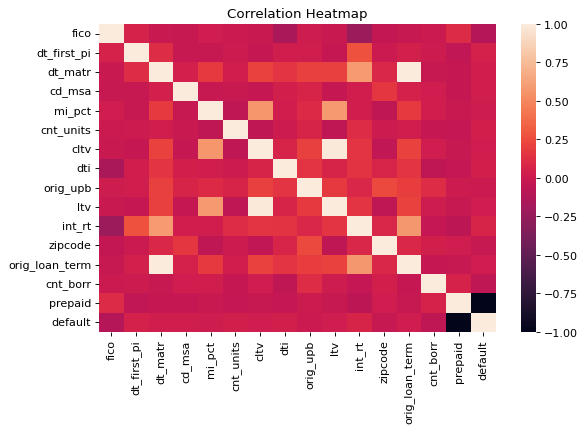

In [31]:
ax = plt.axes()
sns.heatmap(d.corr(numeric_only=True), ax = ax)

ax.set_title('Correlation Heatmap')
plt.show()

We can see, above, a correlation heatmap for every numerical feature in the dataset. We observe three really high correlations (1 or -1) between some of the variables that need to be looked at. First of all, we see that Prepaid and Default are fully correlated. This is normal, as we only have early loans and therefore, the consumers that have not defaulted prepaid their loans and vice versa. Secondly, another obvious relation is the Maturity Date and the originial loan term as the latest is considered as the number of scheduled monthly payments of the mortgage based on the First Payment Date and Maturity Date. Finally, there is an evident correlation between the Loan To Value and the Combined Loan To Value.
We also observe a quite important negative relation between Default and Fico. Indeed, this makes sense as consumers that have a high credit score are less likely to default. 

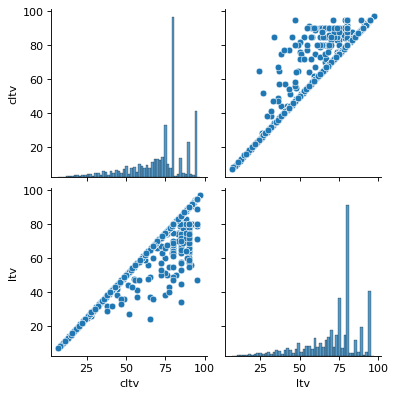

In [32]:
sns.pairplot(d[["cltv","ltv"]])

<Axes: xlabel='default', ylabel='fico'>

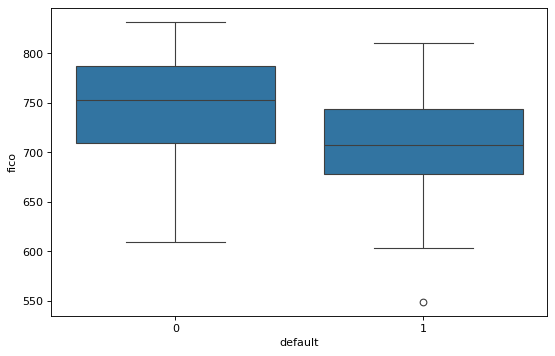

In [33]:
sns.boxplot(d, x = "default", y = "fico")

Above, we can observe three graphics that represent the relationships that we discovered on the heatmap. The correlation between default and fico is as important as we thought it was. 

In [34]:
d["year_first_pi"] = [int(str(i)[0:4]) for i in d["dt_first_pi"]]
d["month_first_pi"] = [int(str(i)[4:]) for i in d["dt_first_pi"]]

d["year_matr"] = [int(str(i)[0:4]) for i in d["dt_matr"]]
d["month_matr"] = [int(str(i)[4:]) for i in d["dt_matr"]]

We decided to encode the dates of first payment and maturity dates differently. Indeed, instead of having only one column of the form YYYYMM, we seperate the dates into two columns : one with the year of the form YYYY and one with the month of the form MM. We thought that it might be easier to interpret this way.

In [35]:
d.ppmt_pnlty.unique()

array(['N', nan], dtype=object)

In [36]:
d.prod_type.unique()

array(['FRM'], dtype=object)

We also observed that the variables 'ppmt_pnlty' and 'prod_type' only take one type of attribute. Therefore, we think that these variables, as well as the ones that we previously mentioned should be dropped.

In [37]:
df_clean = d.drop(columns=['ppmt_pnlty', 'prod_type', 'prepaid', 'dt_first_pi', 'dt_matr', 'flag_fthb', 'id_loan', 'zipcode'], axis=1)

We dropped the unwanted variables previously discussed and stored the wanted data into a new data frame. Furthermore, we also drop the variable 'id_loan' which is just and identifier as it is only present to identify the subject, and the variable 'zipcode' as we already have multiple and better geographical variables in our data set.

In [38]:
df_clean = df_clean[~df_clean.isnull().any(axis=1)]
df_clean

,fico,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,int_rt,...,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,default,year_first_pi,month_first_pi,year_matr,month_matr
1,649.0,33124.0,0,1,P,52.0,22.0,190000,52.0,2.875,...,180,2,Other sellers,Other servicers,N,0,2017,3,2032,2
2,747.0,41180.0,0,1,I,43.0,20.0,61000,43.0,4.000,...,240,2,Other sellers,Other servicers,N,0,2017,3,2037,2
3,711.0,20260.0,0,1,I,80.0,21.0,90000,80.0,4.625,...,360,2,Other sellers,Other servicers,N,0,2017,3,2047,2
7,714.0,19804.0,0,1,I,80.0,22.0,224000,80.0,5.125,...,360,2,Other sellers,Other servicers,N,0,2017,3,2047,2
11,710.0,19660.0,0,1,P,78.0,39.0,295000,78.0,4.625,...,360,2,Other sellers,NATIONSTARMTGELLCDBA,N,0,2017,3,2047,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6098,812.0,40140.0,0,1,P,78.0,26.0,427000,78.0,4.625,...,360,1,"WELLSFARGOBANK,NA","WELLSFARGOBANK,NA",N,0,2018,11,2048,10
6099,725.0,41500.0,0,1,P,59.0,40.0,160000,59.0,5.000,...,360,2,"WELLSFARGOBANK,NA","WELLSFARGOBANK,NA",N,0,2018,11,2048,10
6100,768.0,31084.0,0,1,P,79.0,46.0,500000,79.0,5.000,...,360,2,"STEARNSLENDING,LLC",Other servicers,Y,0,2018,9,2048,8
6101,752.0,39900.0,0,1,I,80.0,12.0,213000,80.0,4.875,...,180,2,Other sellers,Other servicers,N,0,2018,11,2033,10


After removing the NAs, we are left with 5507 observations, which is still substantial, as we keep aproximatively 90% of the consumers data. We also need to make sure that the remaining observations also have a default rate similar at what we previously had, prior to handling the NAs. We are quite happy, as the defaults are aproximately 1.60% of the final data (compared to the 1.85% we previously had).

In [39]:
100*df_clean.default.value_counts()[1]/(df_clean.default.value_counts()[0]+df_clean.default.value_counts()[1])

1.5979662248047939

Now that we have looked at variables related to the clients credit and the related mortgages, handled the missing values, dropped the unwanted variables and visualized several correlation, we focus in seeing, geographicaly, how the consumers are distributed over the United States.

In [40]:
msa_shapes = gpd.read_file("msa.geojson")

msa_shapes["cbsafp"] = msa_shapes["cbsafp"].astype("int64")

msa_count = df_clean['cd_msa'].value_counts().reset_index()
msa_count.columns = ['cbsafp', 'Count']

msa_count["cbsafp"] = msa_count["cbsafp"].astype("int64")

In [41]:
#division codes to MSA codes (codes ending with 4 are division codes)
#Sources
#https://www.bls.gov/sae/additional-resources/metropolitan-and-necta-divisions-published-by-ces.htm
#https://tbed.org/demo/index.php?tablename=cbsa&function=details&where_field=cbsa_code&where_value=14460
#https://pcidownloads.com/crawiz/pcidownload/CRA%20Wiz/Performance%20Context/MSA/2024%20MSA%20Connecticut%20County%20Changes%20Guide.pdf
#https://www2.census.gov/programs-surveys/metro-micro/geographies/reference-files/2018/delineation-files/list1_Sep_2018.xls
msa_div_dict = {16980: [16974, 16984, 20994, 23844, 29404],
                19100: [19124, 23104],
                19820: [19804, 47664],
                31080: [11244, 31084],
                33100: [22744, 33124, 48424],
                35620: [20524, 35004, 35084, 35614, 35154],
                37980: [15804, 33874, 37964, 48864],
                41860: [36084, 41884, 42034],
                42660: [42644, 45104],
                47900: [43524, 47894, 23224],
                71650: [71654, 72104, 73104, 73604, 74204, 74804, 74854, 75404, 76524, 78254],
                14460: [14454, 15764, 40484]}

In [42]:
#reverse keys with values
div_msa_dict = {val: key for key, values in msa_div_dict.items() for val in values}

#some codes were replaced with new ones, but the geoJSON we use does not recognize them, so we need to change them manually
div_msa_dict[19430] = 19380
div_msa_dict[39150] = 39140

#https://www.ffiec.gov/census/htm/2015CensusInfoSheet.htm
#19380 changed to 19430
#39100 - new metropolitan area, not in the geoJSON file, luckily only 1 observation there
#39140 changed to 39150

new_df = {}

for index, row in msa_count.iterrows():    
    
    #find replacing MSA code if exists, else return the curr_code
    curr_code = row['cbsafp']
    curr_code = div_msa_dict.get(curr_code, curr_code)
    curr_value = row['Count']
    
    if curr_code in new_df:
        new_df[curr_code] += curr_value
    else:
        new_df[curr_code] = curr_value

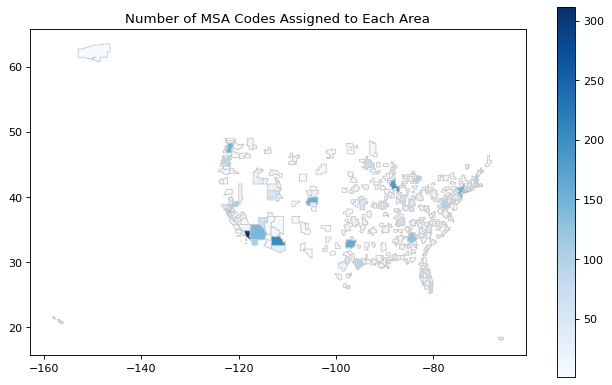

In [43]:
data_msa_count = {'cbsafp': list(new_df.keys()), 'Count': list(new_df.values())} 
msa_count = pd.DataFrame(data_msa_count)
msa_shapes = msa_shapes.merge(msa_count, on='cbsafp', how='left')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
msa_shapes.plot(column='Count', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cmap = "Blues")
ax.set_title('Number of MSA Codes Assigned to Each Area')
plt.show()

As we observe on the map, the borrowers are from all 50 states (plus DC). We can even see that some of them are also from Puerto Rico, and the Virgin Islands. The maximum seems to be obtained at the frontier between Arizona and California.

In [44]:
#split the data
data_x, data_y = df_clean.drop(['default'], axis=1), df_clean['default']

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state=42, stratify=data_y)

Finally, we separate the covariates from the target variable and we split the data in to training and test datasets. We use stratifying because, as we have seen earlier, the data is highly imbalanced and we want to make sure that we get a correct number of default in each datasets.

In [45]:
#Oversample the train set, leave the test/valid sets as they are
oversample = RandomOverSampler(sampling_strategy='minority')
X_otrain, y_otrain = oversample.fit_resample(X_train, y_train)

#Undersample the train set, leave the test/valid sets as they are
undersample = RandomUnderSampler(sampling_strategy='majority')
X_utrain, y_utrain = undersample.fit_resample(X_train, y_train)

Since we have an imbalanced dataset, we want to use either oversample or undersample for the training the dataset without touching the test dataset.

To improve our model performance, we use One Hot Encoding on multiple variables related to the type of properties, lenders and loans but also the States in which the properties are located. Furthermore, we also need to take care of the the ordinal variable 'flag_sc' that flags whether or not the mortgages exceed conforming loan limits with origination dates on or after 10/1/2008 and were delivered to Freddie Mac on or after 1/1/2009. Our aim is to retain the ordinal information between categories. To do that, we simply use Ordinal Encoding.

In [46]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ["occpy_sts","channel","prop_type","loan_purpose","st"]),
        ('ord', OrdinalEncoder(),["flag_sc"])
    ],
    remainder='passthrough'
)

In [47]:
scaler = StandardScaler()

# Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, interaction terms, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validating it.*

*For example if you considered a linear regression model, a polynomial regression, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide comparison of your model with baseline model(s) on the test data but only briefly describe the baseline model(s) considered*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a government official or charity directy, who is understands the pressing challenges associated with ageining and dementia but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also mention potential limitations of your model.*

*Finally, you should include recommendations on potential lifestyle changes or governmental/societal interventions to reduce dementia risk.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# References

*Include references if any*

In [48]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2MaxEDA.ipynb

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbconvert` not found.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2a9ec8d-a343-4210-b36b-f9db26268fc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>